# Group Project

ALL POLICY ANALYSIS - Using All_Policy_Data_v2.csv as data source.

# 1. Import Libraries and Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc

In [2]:
# delete the legacy files from the workbook
!rm /content/sample_data/*.*

In [3]:
# attach the local google drive - select your UPenn google account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# validate that you have access to the group project raw data archive folder
!ls -al "/content/drive/Shareddrives/CIS 5450 Group Project/Data"

total 2623202
-rw------- 1 root root 598085787 Apr 12 11:50  All_Policy_Data.csv
-rw------- 1 root root 417116605 Apr 17 18:40  All_Policy_Data_v2.csv
-rw------- 1 root root 656133164 Apr 12 11:51  Clean_Policy_Data.csv
-rw------- 1 root root    234987 Apr 12 11:51  Clean_Policy_Data_SAMPLE.csv
-rw------- 1 root root 499129205 Apr 12 11:51  GL_Policy_Data.csv
-rw------- 1 root root 360596483 Apr 17 18:40  GL_Policy_Data_v2.csv
drwx------ 2 root root      4096 Mar 29 13:39 'Raw Archive'
-rw------- 1 root root  98336072 Apr 12 11:51  WC_Policy_Data.csv
-rw------- 1 root root  56520690 Apr 17 18:40  WC_Policy_Data_v2.csv


In [5]:
source = "/content/drive/Shareddrives/CIS 5450 Group Project/Data/All_Policy_Data_v2.csv"
destination = "/content/sample_data/"
!cp "$source" "$destination"

In [6]:
# Create initial data frame for policy data (takes ~20 seconds)
all_policy_data_df = pd.read_csv("./sample_data/All_Policy_Data_v2.csv", encoding="utf-8", dtype={'column_8': str, 'column_40': str},  low_memory=False)
print("Clean Policy Data - GL (General Liability)")
print("   Column Count: {}".format(all_policy_data_df.shape[1]))
print("   Row Count:    {}".format(all_policy_data_df.shape[0]))

Clean Policy Data - GL (General Liability)
   Column Count: 35
   Row Count:    973490


# 2. Filter and Prep Data for Analysis


In [7]:
#Filter needed data for analysis
policy_data_df = all_policy_data_df[["ProductMasterCoverageTypeName", "ProductMasterLineName", "ProductLineName", "StateCode", "CompanySalesAmt_USD", "EmployeesTotalCount", "SIC_2_Code", "CarrierMasterParentName", "TierName", "BilledPremium", "DCF_Revenue", "Limits", "Exposure", "HasAudit"]]

In [8]:
#review data shape
policy_data_df.shape

(973490, 14)

In [9]:
#drop nulls
policy_data_df = policy_data_df.dropna()
#In descriptive analysis "SIC_2_Code" showed to have "UNKNOWN" value, that is being dropped
policy_data_df = policy_data_df[policy_data_df["SIC_2_Code"] != "UNKNOWN"]

In [10]:
#review data shape
policy_data_df.shape

(101961, 14)

In [11]:
# policy_data_df.head(10)

In [12]:
policy_data_df.describe()

,CompanySalesAmt_USD,EmployeesTotalCount,BilledPremium,DCF_Revenue,Limits,Exposure,HasAudit
count,1.019610e+05,101961.000000,1.019610e+05,101961.000000,1.019610e+05,1.019610e+05,101961.000000
mean,2.133828e+08,457.648424,7.979077e+04,5130.389600,5.421145e+06,3.419054e+07,0.441541
std,4.368565e+09,4699.584114,2.605831e+05,15687.844504,9.397711e+06,4.274068e+08,0.496573
min,0.000000e+00,0.000000,-5.655480e+05,-61768.880000,2.400000e+01,0.000000e+00,0.000000
25%,1.592340e+05,4.000000,2.146000e+03,122.400000,3.000000e+06,4.000000e+04,0.000000
50%,9.877320e+05,11.000000,1.087300e+04,714.900000,5.055000e+06,9.350000e+05,0.000000
75%,1.481466e+07,80.000000,5.586500e+04,3486.750000,6.505000e+06,7.375000e+06,1.000000
max,1.565950e+11,150000.000000,1.800532e+07,697520.330000,1.500000e+09,5.200000e+10,1.000000


In [13]:
policy_data_df.dtypes

ProductMasterCoverageTypeName     object
ProductMasterLineName             object
ProductLineName                   object
StateCode                         object
CompanySalesAmt_USD              float64
EmployeesTotalCount              float64
SIC_2_Code                        object
CarrierMasterParentName           object
TierName                          object
BilledPremium                    float64
DCF_Revenue                      float64
Limits                           float64
Exposure                         float64
HasAudit                           int64
dtype: object

## Correlation of Numeric Dimensions

In [14]:
# creating df for numeric dimensions
numerics_df = policy_data_df[['CompanySalesAmt_USD','EmployeesTotalCount', 'BilledPremium','DCF_Revenue','Limits','Exposure']]

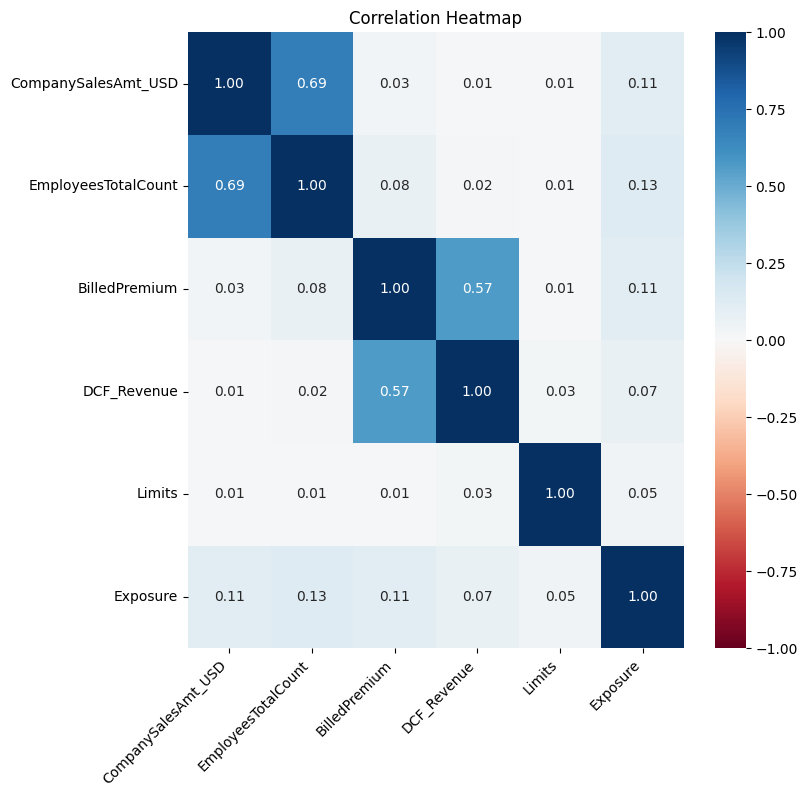

In [15]:
# plot correlation heatmap for numeric dimensions
corr_mat = numerics_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(data=corr_mat, annot=True, cmap="RdBu", fmt=".2f", vmin=-1, vmax=1)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Heatmap")
plt.show()

## One Hot Encoding

Transform categorical columns into binary dummy variables for machine learning preprocessing


In [16]:
# dropping "DCF_Revenue" due to correlation with Billed Premium (after also consulting with SME)
policy_data_df.drop(columns=['DCF_Revenue'], inplace=True)

# creating a new dataframe policy_encoded_df with binary columns for each unique category in the specified columns
policy_encoded_df = pd.get_dummies(data=policy_data_df,columns=["ProductMasterCoverageTypeName", "ProductMasterLineName", "ProductLineName", "StateCode", "SIC_2_Code", "CarrierMasterParentName", "TierName"])
# policy_encoded_df

In [17]:
# convert the 'HasAudit' column to Boolean: set True if the value is 1, otherwise False.
policy_encoded_df['HasAudit'] = policy_encoded_df['HasAudit'].apply(lambda x: True if x == 1 else False )
print(policy_encoded_df['HasAudit'].dtype)

bool


In [18]:
policy_encoded_df.shape

(101961, 393)

In [19]:
# check columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# print(policy_encoded_df.dtypes)

## Checking the Balance of Classification Labels

In [20]:
audit_entries = policy_encoded_df[policy_encoded_df["HasAudit"] == 1]
non_audit_entries = policy_encoded_df[policy_encoded_df["HasAudit"] == 0]

ratio_classification_labels = non_audit_entries.shape[0] / audit_entries.shape[0]
print(f'No audit entries / Audit entries = {ratio_classification_labels: .2f}')

No audit entries / Audit entries =  1.26


<Axes: xlabel='HasAudit', ylabel='count'>

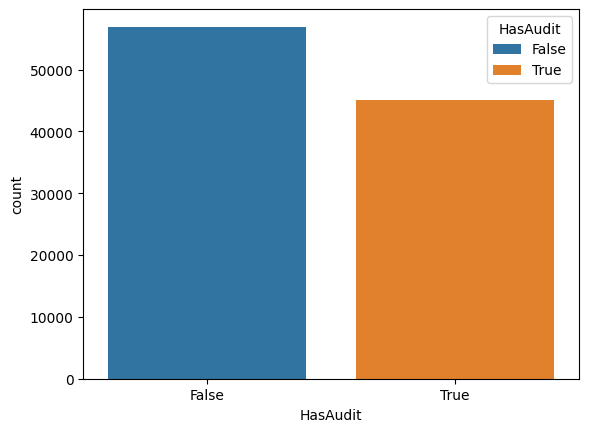

In [21]:
#plot the count of HasAudit datapoints
sns.countplot(x='HasAudit',data=policy_encoded_df, hue='HasAudit')

# 3. Modeling

## Preprocessing: Create Features and Label and Split Data into Train and Test

In [22]:
# store features dataframe into variable called "features"
features = policy_encoded_df.drop(columns=["HasAudit"])

In [23]:
# store the classification target variable into "target"
target = policy_encoded_df["HasAudit"]

In [24]:
# Assign appropriate value to seed and conduct 80/20 train-test split with random_state = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 42)

## Initial Logistic Regression without PCA

In [25]:
# Initialize model with default parameters and fit it on the training set
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test)

# Find the accuracy and store the value in `log_acc`
lr_acc_wo_pca = accuracy = accuracy_score(y_pred, y_test)
print(f"Initial Logistic Regression without PCA, accuracy:", round(lr_acc_wo_pca*100,1), "%")

Initial Logistic Regression without PCA, accuracy: 65.6 %


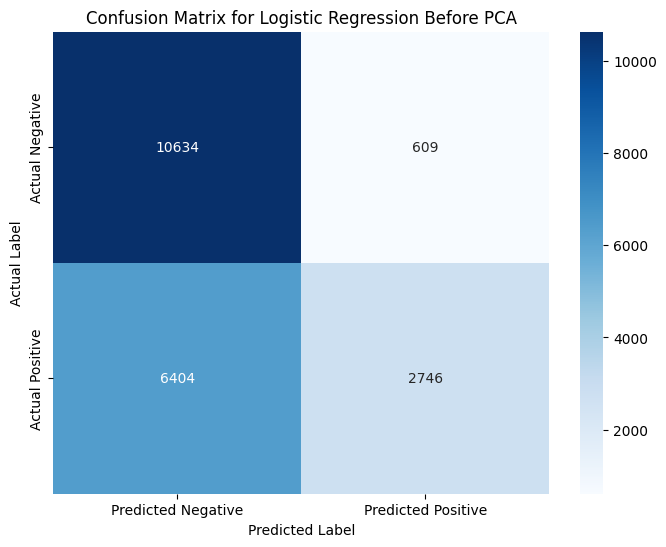

In [26]:
# compute the confusion matrix and save it to `lr_confusion`
lr_confusion = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix (https://www.kaggle.com/code/agungor2/various-confusion-matrix-plots)
plt.figure(figsize=(8,6))
sns.heatmap(lr_confusion, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression Before PCA')
plt.show()

In [27]:
# calculate precision, recall, F-score, and support for each class
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

# precision: The ratio of correctly predicted positive observations to the total predicted positives
print(f'Precision of 0 (no-audit): {precision[0]*100:.1f}% | Precision of 1 (audit):{precision[1]*100:.1f}%\n')

# recall: The ratio of correctly predicted positive observations to all observations in actual class
print(f'Recall of 0 (no-audit): {recall[0]*100:.1f}%  | Recall of 1 (audit):{recall[1]*100:.1f}%\n')

# F-score: The weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account
print(f'F-score of 0 (no-audit): {fscore[0]*100:.1f}%  | F-score of 1 (audit):{fscore[1]*100:.1f}%\n')

# support: The number of actual occurrences of the class in the specified dataset
print(f'Support of 0 (no-audit): {support[0]:.0f}  | Support of 1 (audit):{support[1]:.0f}\n')

Precision of 0 (no-audit): 62.4% | Precision of 1 (audit):81.8%

Recall of 0 (no-audit): 94.6%  | Recall of 1 (audit):30.0%

F-score of 0 (no-audit): 75.2%  | F-score of 1 (audit):43.9%

Support of 0 (no-audit): 11243  | Support of 1 (audit):9150



##Random Forest Classifier (Ensemble - Bagging)

In [28]:
# initialize model with default parameters and fit it on the training set
clf = RandomForestClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

# use the model to predict on the test set and save these predictions as `y_pred_rfc`
y_pred_rfc = clf.predict(X_test)

# find the accuracy and store the value in `rf_acc`
rf_acc = accuracy_score(y_pred_rfc, y_test)
print(f"Initial Random Forest without PCA, accuracy:", round(rf_acc*100,1), "%")

Initial Random Forest without PCA, accuracy: 85.5 %


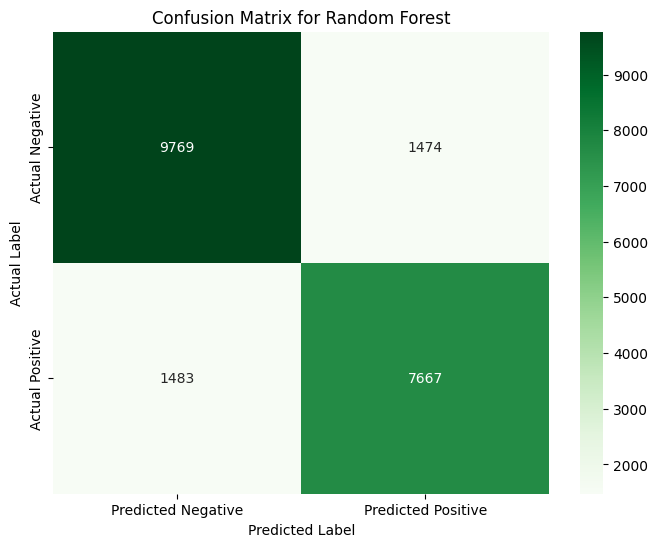

In [30]:
# compute the confusion matrix and save it to `rf_confusion`
rf_confusion = confusion_matrix(y_test, y_pred_rfc)

# visualize the confusion matrix (https://www.kaggle.com/code/agungor2/various-confusion-matrix-plots)
plt.figure(figsize=(8,6))
sns.heatmap(rf_confusion, annot=True, fmt="d", cmap='Greens', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [31]:
# calculate precision, recall, F-score, and support for each class
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_rfc)

# precision: The ratio of correctly predicted positive observations to the total predicted positives
print(f'Precision of 0 (no-audit): {precision[0]*100:.1f}% | Precision of 1 (audit):{precision[1]*100:.1f}%\n')

# recall: The ratio of correctly predicted positive observations to all observations in actual class
print(f'Recall of 0 (no-audit): {recall[0]*100:.1f}%  | Recall of 1 (audit):{recall[1]*100:.1f}%\n')

# F-score: The weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account
print(f'F-score of 0 (no-audit): {fscore[0]*100:.1f}%  | F-score of 1 (audit):{fscore[1]*100:.1f}%\n')

# support: The number of actual occurrences of the class in the specified dataset
print(f'Support of 0 (no-audit): {support[0]:.0f}  | Support of 1 (audit):{support[1]:.0f}\n')

Precision of 0 (no-audit): 86.8% | Precision of 1 (audit):83.9%

Recall of 0 (no-audit): 86.9%  | Recall of 1 (audit):83.8%

F-score of 0 (no-audit): 86.9%  | F-score of 1 (audit):83.8%

Support of 0 (no-audit): 11243  | Support of 1 (audit):9150



### Entropy

Entropy is calced as a measure of the average uncertainty in the model's predictions across the test set.

A higher entropy indicates higher uncertainty and possibly greater variability in the confidence of the predictions.

In [34]:
#entropy function
def entropy(probs):
    return -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])

#predict class probabilities
prob_predictions = clf.predict_proba(X_test)

#calc entropy for each set of class probabilities
entropies = np.array([entropy(p) for p in prob_predictions])

#calculate mean entropy across all predictions
mean_entropy = np.mean(entropies)
print(f"Mean entropy of the RandomForestClassifier predictions: {round(mean_entropy,2)}")

Mean entropy of the RandomForestClassifier predictions: 0.39


### The ROC Graph and AUC

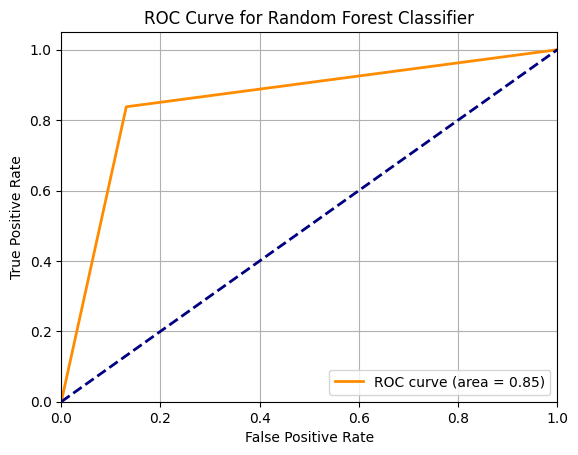

In [35]:
#compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_rfc)
roc_auc = auc(fpr, tpr)

#plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## PCA to Reduce Dimensionality

### Scale the Data

In [36]:
# scale the data for PCA
X_train_scaled = StandardScaler().fit_transform(X_train)

### Initial PCA

In [37]:
#apply PCA - instantiate and fit PCA
pca = PCA()
PCA_X_train = pca.fit_transform(X_train_scaled)

In [38]:
# save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_

# save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = explained_variance_ratios.cumsum()

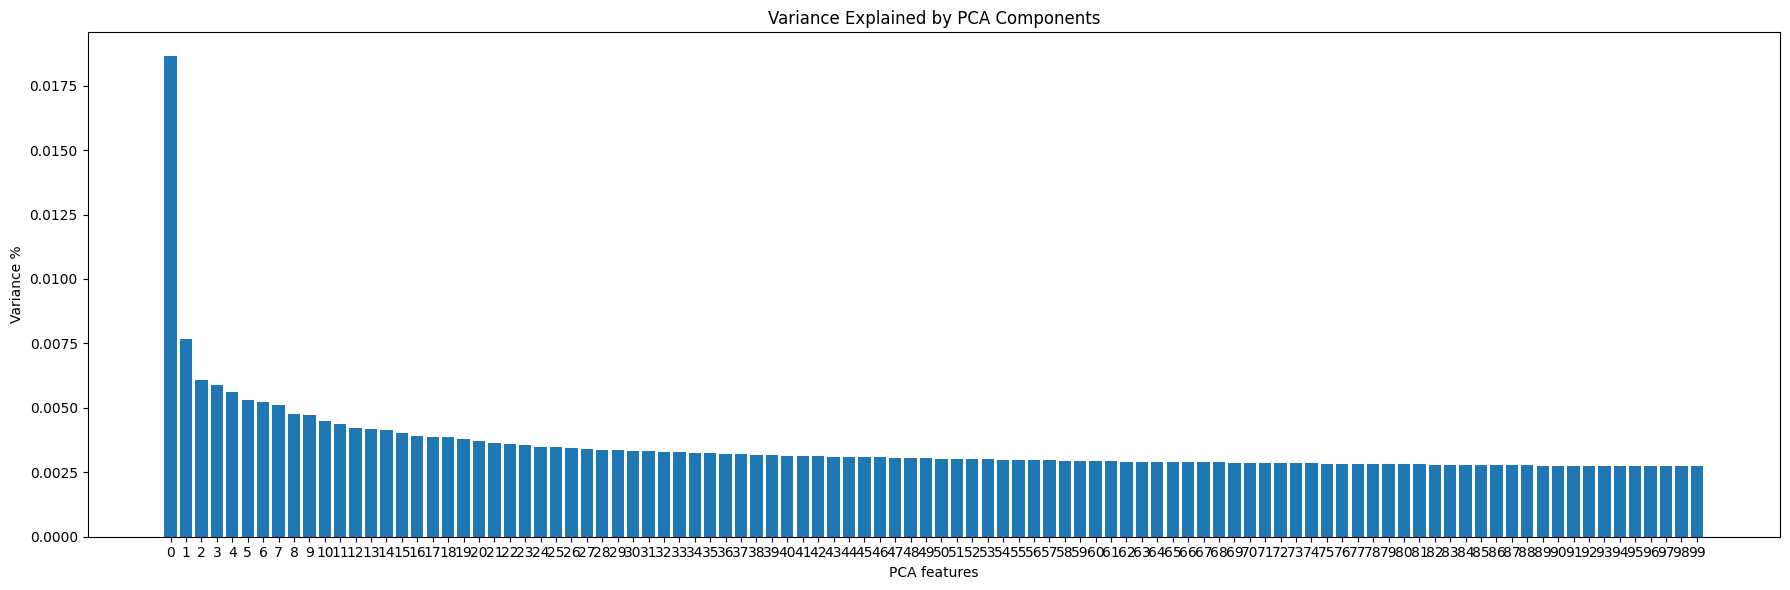

In [40]:
# scree plot shows the variance explained by each principal component. It's useful to decide how many components to keep
# plot the explained variances
plt.figure(figsize=(18, 6))

features = range(pca.n_components_)[0:100]

plt.bar(features, explained_variance_ratios[0:100])
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title('Variance Explained by PCA Components')
plt.tight_layout()

plt.show()

In [41]:
# Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_

# Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = pca.explained_variance_ratio_.cumsum()

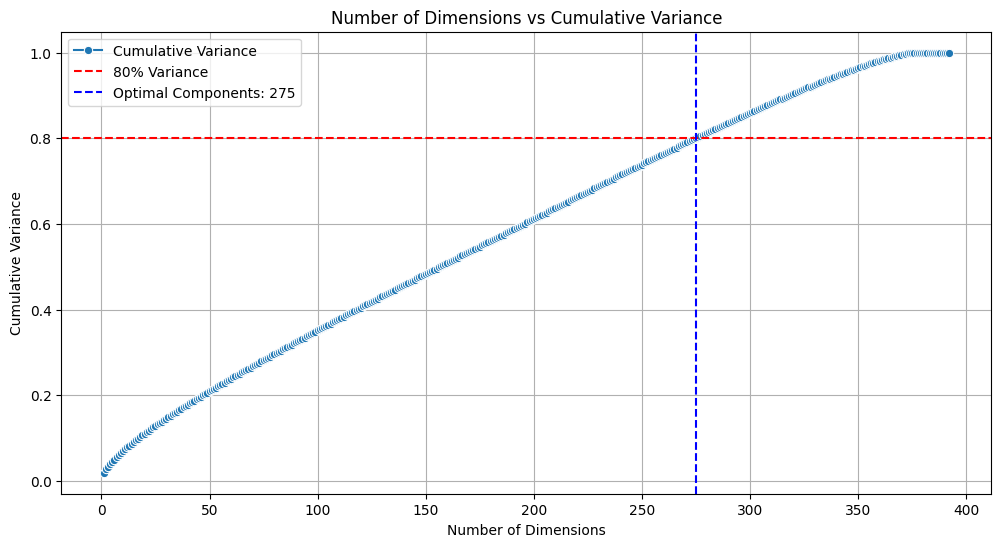

Optimal number of components: 275


In [42]:
# finding the point where cumulative variance exceeds or meets 0.80
optimal_components = np.where(cum_evr >= 0.80)[0][0] + 1  # adding 1 because index is 0-based

plt.figure(figsize=(12, 6))
x_values = np.arange(1, len(cum_evr) + 1)
sns.lineplot(x=x_values, y=cum_evr, marker='o', label='Cumulative Variance')

# Add a horizontal line at y=0.80 and vertical line at the optimal component
plt.axhline(y=0.80, color='red', linestyle='--', label='80% Variance')
plt.axvline(x=optimal_components, color='blue', linestyle='--', label=f'Optimal Components: {optimal_components}')

plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Variance")
plt.title("Number of Dimensions vs Cumulative Variance")
plt.legend()
plt.grid(True)

plt.show()

# Print optimal number of components
print("Optimal number of components:", optimal_components)

### Final PCA

Using results above to decided the number of components to keep is 275 (n=275), which explains at least 80% of total variance in the dataset. Then re-fitted and transformed the PCA on the training set using the decided n.

The PCA is trained on the training set (X_train) and only transformed on the test set (X_test).


In [44]:
# refit and transform on training
scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train)

# transform on Testing Set
pca = PCA(n_components=275)
X_train_pca = pca.fit_transform(X_train_scl)
X_test_scl = scl.transform(X_test)
X_test_pca = pca.transform(X_test_scl)

In [45]:
#We are attempting to find the features (in sorted order) that PCA keeps (i.e. those columns that explain the 80% of cumulative variance)
features = policy_encoded_df.drop(columns=["HasAudit"])
column_names = features.columns

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [column_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
display(df)

,0,1
0,PC0,ProductMasterCoverageTypeName_CASUALTY
1,PC1,ProductMasterLineName_C - WORKERS COMPENSATION...
2,PC2,TierName_TIER 3
3,PC3,TierName_REGIONAL
4,PC4,TierName_SPECIALTY
5,PC5,TierName_SPECIALTY
6,PC6,CarrierMasterParentName_UNKNOWN
7,PC7,TierName_UNKNOWN
8,PC8,CarrierMasterParentName_DISTRIBUTORS INSURANCE...
9,PC9,ProductLineName_COMMERCIAL GENERAL LIABILITY


## K-Means Clustering

### PCA to Reduce Dimensionality

In [ ]:
#fit and transform StandardScaler on training data
scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train)

#transform training and testing sets with PCA
pca = PCA(n_components=275)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_scaled = scl.transform(X_test)
features_pca_k = pca.transform(X_test_scaled)

### Find the best number of clusters with the elbow plot

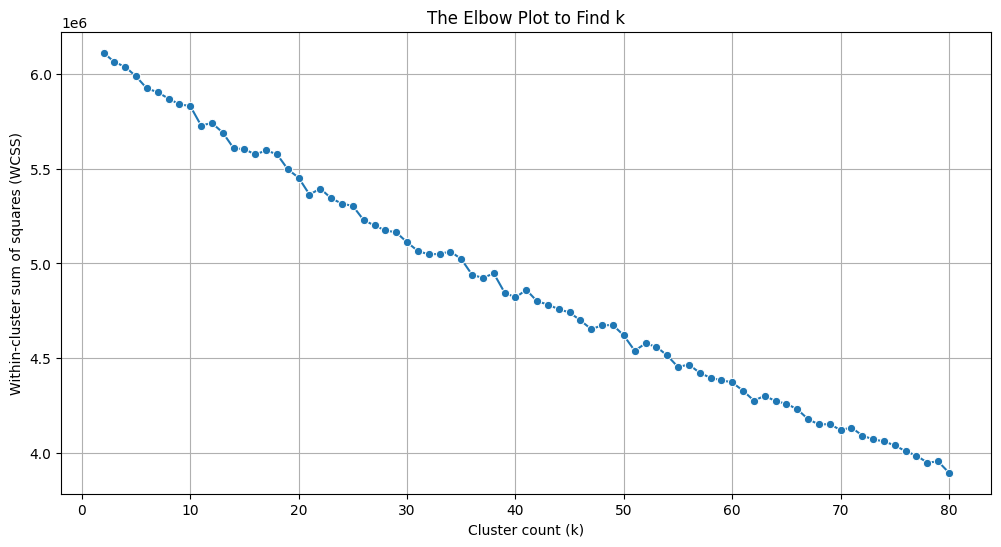

In [ ]:
visulizing number of clusters - WARNING: takes a long time to run, update max_k!
distortions = []
# max_k = 10
# max_k = 80
for i in range(2, max_k+1):
  km = KMeans(n_clusters=i, random_state=0, n_init=5)
  km.fit(features_pca_k)
  # The distortion
  distortions.append(km.inertia_)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(2,max_k+1), y=distortions, marker='o')

plt.xlabel("Cluster count (k)")
plt.ylabel("Within-cluster sum of squares (WCSS)")
plt.title("The Elbow Plot to Find k")
plt.grid(True)

plt.show()

## Logistic Regression after PCA

In [46]:
# initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, y_train)

# use the model to predict on the PCA transformed test set and save these predictions as `y_pred_lr`
y_pred_lr = log_reg_pca.predict(X_test_pca)

# find the accuracy and store the value in `lr_acc_after_pca`
lr_acc_after_pca = accuracy_score(y_pred_lr, y_test)

print(f"Before PCA, Logistic Regression Accuracy was:", round(lr_acc_wo_pca*100,1), "%")
print(f"After PCA, Logistic Regression Accuracy is:", round(lr_acc_after_pca*100,1), "%")

Before PCA, Logistic Regression Accuracy was: 65.6 %
After PCA, Logistic Regression Accuracy is: 80.0 %


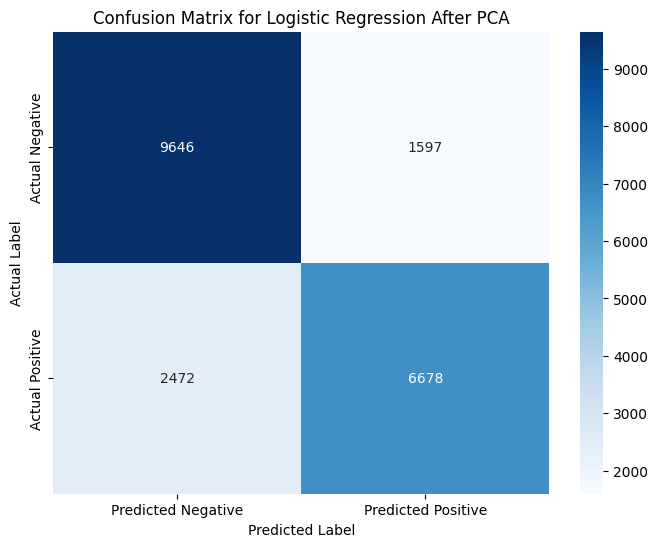

In [47]:
# compute the confusion matrix and save it to `lr_confusion_after_pca`
lr_confusion_after_pca = confusion_matrix(y_test, y_pred_lr)

# visualize the confusion matrix (https://www.kaggle.com/code/agungor2/various-confusion-matrix-plots)
plt.figure(figsize=(8,6))
sns.heatmap(lr_confusion_after_pca, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression After PCA')
plt.show()

In [48]:
# calculate precision, recall, F-score, and support for each class
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_lr)

# precision: The ratio of correctly predicted positive observations to the total predicted positives
print(f'Precision of 0 (no-audit): {precision[0]*100:.1f}% | Precision of 1 (audit):{precision[1]*100:.1f}%\n')

# recall: The ratio of correctly predicted positive observations to all observations in actual class
print(f'Recall of 0 (no-audit): {recall[0]*100:.1f}%  | Recall of 1 (audit):{recall[1]*100:.1f}%\n')

# F-score: The weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account
print(f'F-score of 0 (no-audit): {fscore[0]*100:.1f}%  | F-score of 1 (audit):{fscore[1]*100:.1f}%\n')

# support: The number of actual occurrences of the class in the specified dataset
print(f'Support of 0 (no-audit): {support[0]:.0f}  | Support of 1 (audit):{support[1]:.0f}\n')

Precision of 0 (no-audit): 79.6% | Precision of 1 (audit):80.7%

Recall of 0 (no-audit): 85.8%  | Recall of 1 (audit):73.0%

F-score of 0 (no-audit): 82.6%  | F-score of 1 (audit):76.6%

Support of 0 (no-audit): 11243  | Support of 1 (audit):9150



### The ROC Graph and AUC

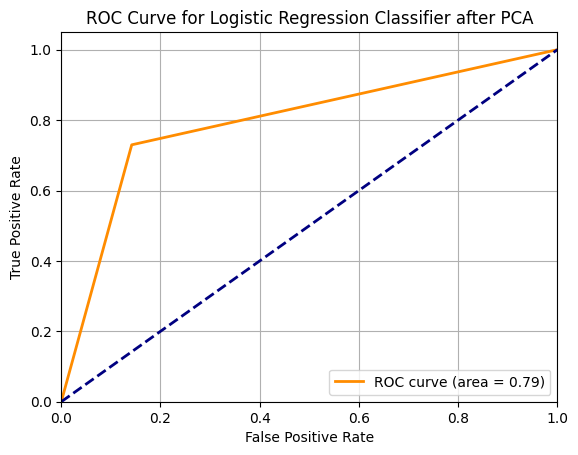

In [49]:
#compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

#plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Classifier after PCA')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Neural Network - Multi-layer Perceptron Classifier (MLPC)

### Prep of Data for MLPC

In [50]:
#reset data - sample data preparation
features = policy_encoded_df.drop(columns=["HasAudit"])
target = policy_encoded_df["HasAudit"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [51]:
#scaling and applying PCA to the data to reduce multicollinearity
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA()
pca.fit_transform(X_train)

array([[ 3.97259903e+00, -1.91774445e+00,  5.49408889e-01, ...,
         1.33930892e-15, -4.12942909e-16,  3.49821013e-16],
       [-8.83176870e-01, -1.18086018e+00,  2.03959347e+00, ...,
         1.30108167e-15, -2.89523755e-16,  2.71182972e-16],
       [-1.05078296e+00, -1.22636169e+00,  1.74246298e+00, ...,
         6.18766977e-15, -5.25346552e-16, -6.76894806e-16],
       ...,
       [ 3.60643794e+00, -1.47888029e+00,  1.24013765e+00, ...,
        -1.04599459e-16, -2.96558350e-18, -9.97228691e-18],
       [-1.90514142e+00,  5.01100407e-01,  1.23574753e+00, ...,
         2.28415222e-18,  2.40961750e-17, -3.30385081e-17],
       [ 2.85270831e+00,  1.09361235e+01,  2.02209165e-01, ...,
         7.02772276e-16, -1.05183118e-16,  1.00664694e-16]])

### MLPC with Logistic Activation Function

In [52]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html #### WARNING - TAKES A LONG TIME (>20-25 mins)
#default parameters except max iter (max_iter of 200, 300, 350, 400, 450 didn't converge)
#set the model - WARNING: takes a long time to run!
mlpc = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', max_iter=500, random_state=42)

# train the model
mlpc.fit(X_train, y_train)

#predict on the test set
y_pred_mlpc = mlpc.predict(X_test)

# model performance
mlpc_accuracy = accuracy_score(y_test, y_pred_mlpc)
mlpc_report = classification_report(y_test, y_pred_mlpc)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
print(f"Neural Network - Multi-layer Perceptron Classifier (MLPC) Accuracy: {round(mlpc_accuracy,2)}\n"),
print("Neural Network - Multi-layer Perceptron Classifier (MLPC) Classification Report:\n", mlpc_report)

Neural Network - Multi-layer Perceptron Classifier (MLPC) Accuracy: 0.83

Neural Network - Multi-layer Perceptron Classifier (MLPC) Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.85      0.85     11243
        True       0.82      0.81      0.81      9150

    accuracy                           0.83     20393
   macro avg       0.83      0.83      0.83     20393
weighted avg       0.83      0.83      0.83     20393



#### The ROC Graph and AUC

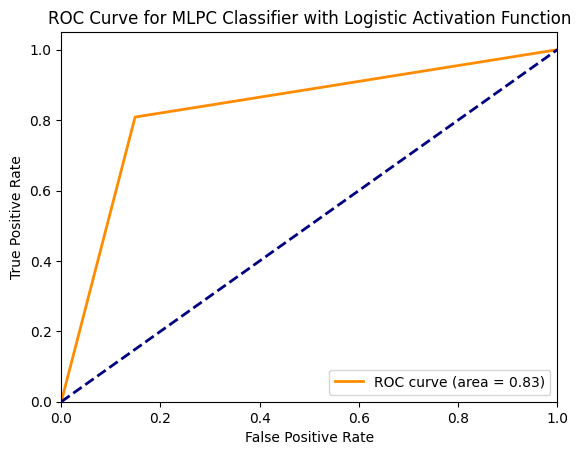

In [54]:
#compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_mlpc)
roc_auc = auc(fpr, tpr)

#plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLPC Classifier with Logistic Activation Function')
plt.legend(loc="lower right")
plt.show()


### MLPC with ReLU Activation Function

In [55]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
#default parameters except ReLU and max_iter (max_iter of 200 didn't converge)
#set the model
mlpc_relu = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=300, random_state=42)

#train the model - WARNING: takes a long time to run!
mlpc_relu.fit(X_train, y_train)

#predict on the test set
y_pred_mlpc_relu = mlpc_relu.predict(X_test)

# model performance
mlpc_relu_accuracy = accuracy_score(y_test, y_pred_mlpc_relu)
mlpc_relu_report = classification_report(y_test, y_pred_mlpc_relu)

In [56]:
print(f"Neural Network - Multi-layer Perceptron Classifier (MLPC) with ReLU Activation Accuracy: {round(mlpc_relu_accuracy,2)}\n"),
print("Neural Network - Multi-layer Perceptron Classifier (MLPC) with ReLU Activation Classification Report:\n", mlpc_relu_report)

Neural Network - Multi-layer Perceptron Classifier (MLPC) with ReLU Activation Accuracy: 0.83

Neural Network - Multi-layer Perceptron Classifier (MLPC) with ReLU Activation Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.84      0.84     11243
        True       0.80      0.82      0.81      9150

    accuracy                           0.83     20393
   macro avg       0.83      0.83      0.83     20393
weighted avg       0.83      0.83      0.83     20393



#### The ROC Graph and AUC

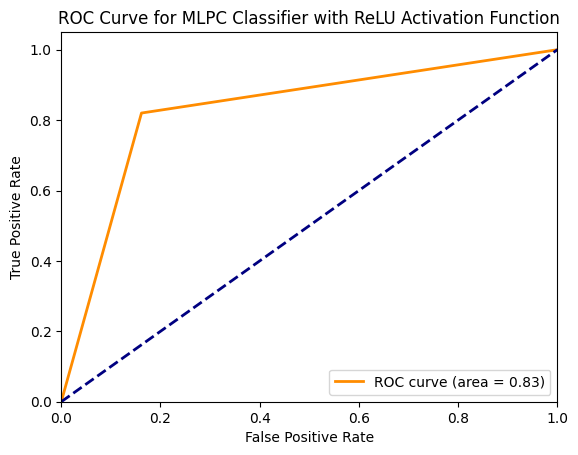

In [57]:
#compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_mlpc_relu)
roc_auc = auc(fpr, tpr)

#plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLPC Classifier with ReLU Activation Function')
plt.legend(loc="lower right")
plt.show()


### Summary of LogisticRegression and RandomForest to Compare with MLPC

In [58]:
#Logistic regression
print(f"Before PCA, Logistic Regression Accuracy is:", round(lr_acc_wo_pca*100,1), "%")
print(f"After PCA, Logistic Regression Accuracy is:", round(lr_acc_after_pca*100,1), "%")

#RandomForest
print(f"Before PCA, Random Forest Classifier Accuracy is:", round(rf_acc*100,1), "%")

Before PCA, Logistic Regression Accuracy is: 65.6 %
After PCA, Logistic Regression Accuracy is: 80.0 %
Before PCA, Random Forest Classifier Accuracy is: 85.5 %
